[View in Colaboratory](https://colab.research.google.com/github/3catz/deeplearning_timeseries/blob/master/SPIDR_By_Wind_Minly_Time_Series_Series_Forecasting_with_EEMD_and_Fully_Convolutional_Neural_Networks.ipynb)

#SPIDR by Wind Minly Time Series Analysis using EMD and Dilated Convolutional Neural Networks


The interplanetary magnetic field (IMF) is a part of the Sun's magnetic field that is carried into interplanetary space by the solar wind. The IMF is a vector quantity with three directional components, two of which (Bx and By) are oriented parallel to the ecliptic. The time series that I am using here is By component.


Using Ensemble Empirical Mode Decomposition and convolutional neural networks, I created an architecture for forecasting one step ahead based on a lookback of 20 time steps. The predictions for the out of sample set are not recursively defined, but are rather based on the ground-truth of the last 20 time steps. The R2 score is pretty good, nonetheless. 

I then use autoML, a python library for ... "automatic machine learning" to compare my results. In this case, I got decent results from the XGBoost Regression model, with R2 score near what I achieved with the EEMD/IMF method. 


In [6]:
!pip install EMD-signal
!pip install pyhht
!pip install PeakUtils
from sklearn.preprocessing import MinMaxScaler, RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import os 
from scipy.integrate import odeint
#keras
from keras.models import *
from keras.layers import * 
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.engine.topology import Layer


Using TensorFlow backend.


# Utilities: series to supervised

In [0]:
def series_to_supervised(data, n_in, n_out, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Loading Data 

In [8]:
from google.colab import files    
files.upload()




Saving SPIDR_windminly.csv to SPIDR_windminly (1).csv


{'SPIDR_windminly.csv': b'-2.346,-1.631,-1.817,-1.428,-0.752,0.544,0.539,-0.336,-2.398,-3.663,-3.36,-3.604,-3.594,0.857,-0.379,-1.56,-0.868,-1.091,-0.321,-0.111,0.748,0.646,0.207,-0.226,0.105,-0.296,0.489,1.046,1.002,1.481,0.567,0.818,1.684,0.821,1.035,0.584,2.145,1.585,0.071,1.31,2.206,1.309,1.342,1.315,1.408,1.544,1.625,-0.205,-4.861,-4.936,-4.295,-4.415,-4.463,0.562,3.855,3.083,3.605,4.195,2.68,2.662,2.733,3.845,3.61,3.92,3.138,3.4,3.62,0.541,-3.76,-4.03,-4.176,-3.051,-1.808,-0.902,1.084,-0.611,-2.44,-1.708,-1.937,-1.205,0.19,0.232,-1.411,-2.055,-0.605,-0.534,-1.045,-1.755,-1.116,-1.098,-0.878,1.181,1.588,1.35,1.332,1.738,2.25,1.76,-2.089,-5.296,-5.132,-4.919,-4.816,-4.09,-4.047,-3.901,-3.591,-3.477,-3.303,-1.807,-0.426,0.948,-0.394,-4.842,-4.808,-4.64,-4.895,-5.297,-5.042,-5.414,-5.568,-5.361,-5.453,-5.474,-4.361,-4.831,-5.016,-5.6,-5.025,-4.411,-5.162,-4.42,-4.754,-5.009,-4.817,-4.641,-4.772,-4.216,-3.541,-3.772,-2.976,-3.205,-3.689,-3.869,-2.342,-0.313,-0.223,-0.912,-0.341,0.265,

In [0]:
import numpy as np  
data = np.fromfile("lorenz.dat", sep = "\n")

data.shape

In [9]:
import numpy as np
data = np.genfromtxt("SPIDR_windminly.csv", delimiter = ","); data = np.asarray(data); data.shape

(10000,)

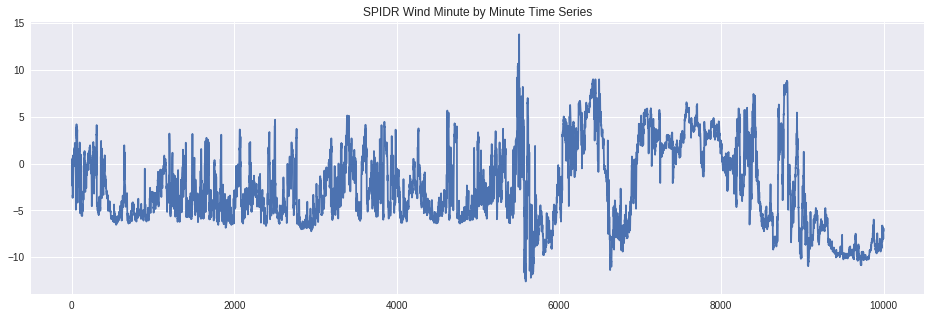

In [7]:
plt.figure(figsize=(16,5))
plt.plot(data)
plt.title("SPIDR Wind Minute by Minute Time Series")
plt.show()

In [10]:
#Scale the Data
scaler = MinMaxScaler(feature_range = (-1,1)) 
scaled_data = scaler.fit_transform(data.reshape(-1,1))
scaled_data.shape
scaled_data = np.squeeze(scaled_data)
scaled_data.shape

(10000,)

In [0]:
scaled_data = np.transpose(scaled_data)

In [12]:
# before you do the EMD, cut out the out of sample part so that the EMDs are not constructed with those future values and information contained within them

in_sample = scaled_data[:-1000]; out_sample = scaled_data[-1000:]
print(in_sample.shape)

(9000,)


In [0]:
in_sample = in_sample.reshape(-1,1)

#Empirical Mode Decomposition


In [0]:

from PyEMD import EEMD 

In [13]:
eemd = EEMD()
eemd.extrema_detection = "simple"
t = np.linspace(0, in_sample.shape[0], in_sample.shape[0])
t = t.reshape(-1,1)
print(t.shape, in_sample.shape)
t = np.squeeze(t)
in_sample = np.squeeze(in_sample)

(9000, 1) (9000, 1)


In [14]:
imfs1 = eemd(in_sample, t)

print(imfs1.shape)

(16, 9000)


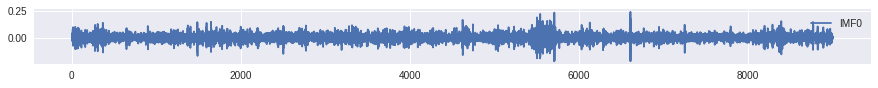

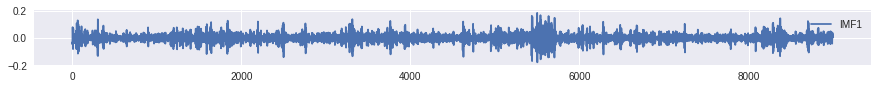

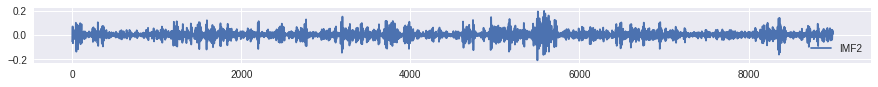

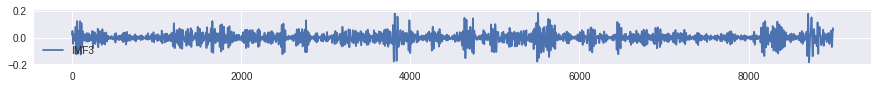

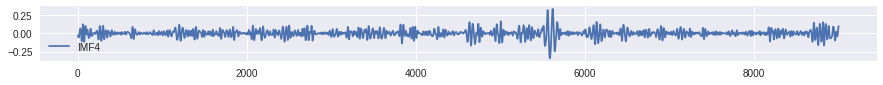

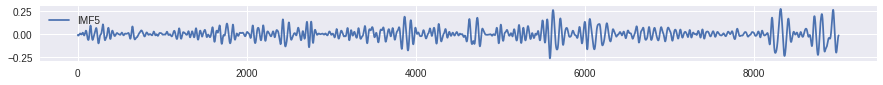

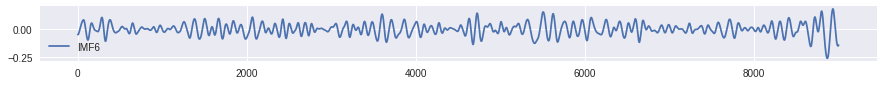

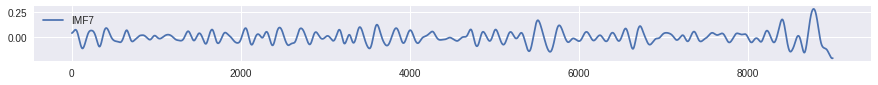

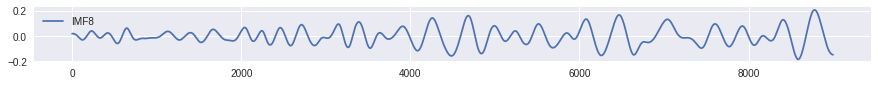

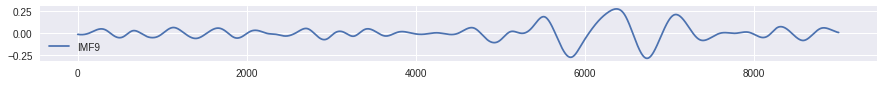

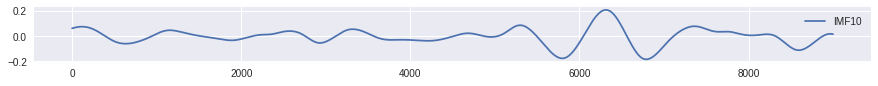

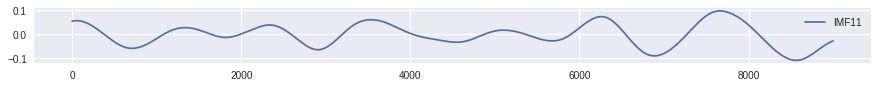

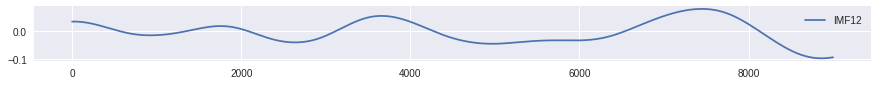

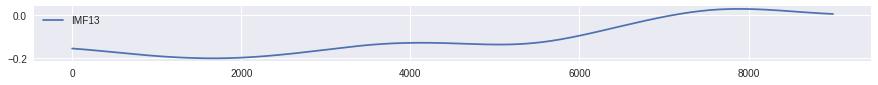

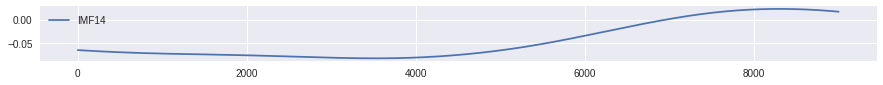

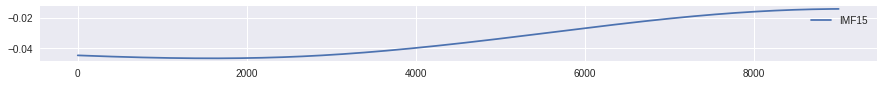

In [15]:
for i in range(len(imfs1)):
  fig, ax = plt.subplots(figsize=(15,1))
  fig = plt.plot(imfs1[i], label = "IMF{}".format(i))
  plt.legend()
  plt.show()

# Creating Datasets


*Raw Data, using lags = 20*

In [14]:
in_sample = in_sample.reshape(-1,1); print(in_sample.shape)

(9000, 1)


In [0]:
from pandas import DataFrame, concat
lookback = 20
data_f = series_to_supervised(in_sample, n_in = lookback, n_out = 1, dropnan = True)

In [19]:
# 
print(data_f.shape)
data_f = np.asarray(data_f)
Xr = data_f[:,:-1]
print(Xr.shape)

(8980, 21)
(8980, 20)


# All IMFs

In [19]:
imfs1.shape

(16, 9000)

In [20]:
imfs1.shape
imfs1 = np.transpose(imfs1, (1,0)); 
print(imfs1.shape)
imf_df = series_to_supervised(imfs1, n_in = lookback, n_out = 1, dropnan = True)
imf_df = np.expand_dims(imf_df, axis = 1)
print(imf_df.shape)
imf_df = np.reshape(imf_df, (8980, 21, 16))

print(imf_df.shape)

(9000, 16)
(8980, 1, 336)
(8980, 21, 16)


In [21]:
#so you want imf_df[:,-1,:]
targets = imf_df[:,-1,:]
print(targets.shape)

(8980, 16)


In [22]:
#so reshape everything properly
input_data = np.reshape(Xr, (8980, 1, 20)); input_permuted = np.reshape(Xr,(8980, 20, 1))
targets = np.reshape(targets,(8980, 1, 16))
print(input_data.shape, targets.shape)

(8980, 1, 20) (8980, 1, 16)


In [59]:
#test Y values 

out_df = series_to_supervised(out_sample.reshape(-1,1), n_in = lookback, n_out = 1, dropnan = True)
print(out_df.shape); out_df = np.asarray(out_df)
testX = out_df[:,:-1]; testX = np.expand_dims(testX, axis = 1); print(testX.shape); 
testY = out_df[:,-1]; print(testY.shape)

(980, 21)
(980, 1, 20)
(980,)


# Partial autocorrelation 

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


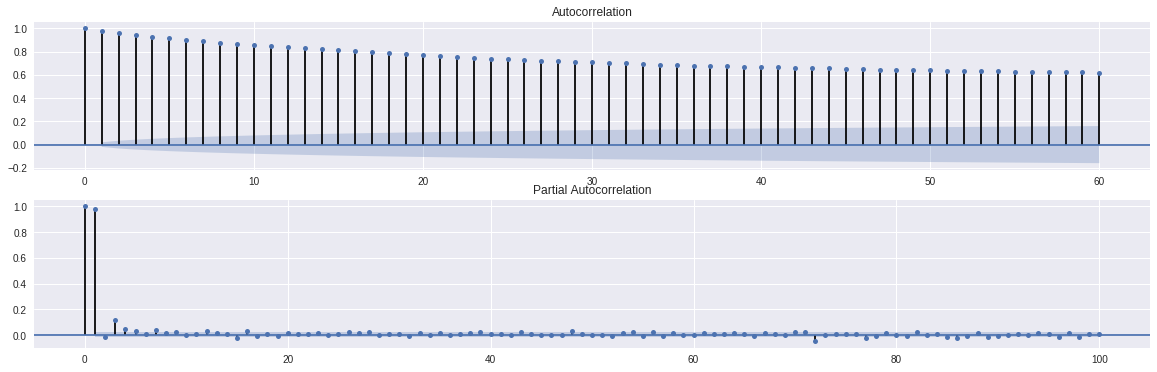

In [25]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(2, figsize=(20,6))
fig1 = plot_acf(scaled_data,lags = 60, ax = axes[0])
fig2 = plot_pacf(scaled_data, lags = 100, ax = axes[1])
plt.show()

# Network Architecture and Model fitting 

In [82]:
from keras.layers.advanced_activations import *
from keras.regularizers import l1, l2 
from sklearn.metrics import r2_score
import keras.backend as K
from keras.layers import LeakyReLU, Permute, Concatenate, Reshape
from keras import optimizers
np.random.seed(2018) 
pad = "causal"
inputs = Input(shape = (1, lookback))
enc = inputs 

x0 = Conv1D(32, 3, padding = pad, dilation_rate = 1, activation = "tanh", 
            kernel_initializer = "glorot_uniform")(enc)


x1 = Conv1D(32, 3, padding = pad, dilation_rate = 4, activation = "tanh",  
           kernel_initializer = "glorot_uniform")(enc)


x2 = Conv1D(32, 3, padding = pad, dilation_rate = 8, activation = "tanh", 
            kernel_initializer = "glorot_uniform")(enc)



x = concatenate([inputs, x0, x1, x2])

predictions = Conv1D(16,  3, padding = pad, dilation_rate = 2, activation = "tanh", kernel_initializer = "glorot_uniform")(x)

model = Model(inputs = inputs, outputs = predictions)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor = 0.9, patience = 3, min_lr = 1e-5, verbose = 1)
checkpointer = ModelCheckpoint(filepath = "timeseries_weights.hdf5", verbose = 1, save_best_only = True)
early = EarlyStopping(monitor = 'loss', min_delta = 1e-5, patience = 30, verbose = 1)

model.compile(optimizer = optimizers.Adadelta(lr = 1, clipnorm = .05), loss='mse', metrics = [])
model.summary()

history = model.fit(input_data, targets, 
          epochs = 20, 
          batch_size = 128, 
          verbose = 1, 
          #validation_data = (validX, validY),
          callbacks = [reduce_lr, early],
          shuffle = False)  


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 20)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1, 32)        1952        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1, 32)        1952        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 1, 32)        1952        input_1[0][0]                    
__________________________________________________________________________________________________
concatenat

NameError: ignored

(980, 1, 16)
(980, 1)
(980,)


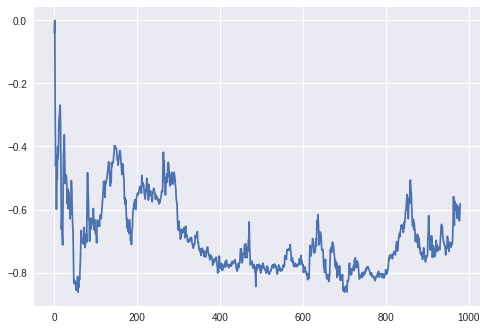

In [82]:
predictions = model.predict(testX, batch_size = 1)
print(predictions.shape)
summed = np.sum(predictions, axis = -1); print(summed.shape)
test_preds = summed[:,0]
plt.plot(test_preds); print(test_preds.shape) #does this match the testY.shape

In [81]:
print("Final R2 Score is: {}".format(r2_score(testY, test_preds)))
from sklearn.metrics import explained_variance_score
print("Final Explained Variance Score is: {}.".format(explained_variance_score(testY, test_preds)))
fig = plt.figure(figsize = (20,6))
fig = plt.plot(test_preds, label = "PREDICTIONS")
fig = plt.plot(testY, label = "TRUE DATA")
plt.xlim([0,200])
plt.legend()
plt.show()

plt.clf()
plt.cla()
plt.close()

NameError: ignored

In [1]:
!pip install auto_ml

    100% |████████████████████████████████| 71kB 4.1MB/s 
    100% |████████████████████████████████| 215kB 7.0MB/s 
    100% |████████████████████████████████| 634kB 10.1MB/s 
    100% |████████████████████████████████| 51kB 10.9MB/s 
    100% |████████████████████████████████| 942kB 10.0MB/s 
  Running setup.py bdist_wheel for sklearn-deap2 ... - done
  Stored in directory: /root/.cache/pip/wheels/bf/3f/41/62181df83b6d15a4054d34227ef40a96d6e4c56ff6773bf9f8
  Running setup.py bdist_wheel for tabulate ... - done
  Stored in directory: /root/.cache/pip/wheels/2a/85/33/2f6da85d5f10614cbe5a625eab3b3aebfdf43e7b857f25f829
  Running setup.py bdist_wheel for deap ... - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/22/ea/bf/dc7c8a2262025a0ab5da9ef02282c198be88902791ca0c6658
Successfully built sklearn-deap2 tabulate deap
  Found existing installation: python-dateutil 2.5.3
    Uninstalling python-dateutil-2.5.3:
      Successfully uninstalled pyth

In [0]:
from auto_ml import Predictor
from auto_ml.utils import get_boston_dataset
from auto_ml.utils_models import load_ml_model



In [53]:
import pandas as pd
trainX = pd.DataFrame(data_f)
print(trainX)

            0         1         2         3         4         5         6   \
0    -0.223303 -0.169171 -0.183253 -0.153802 -0.102623 -0.004505 -0.004883   
1    -0.169171 -0.183253 -0.153802 -0.102623 -0.004505 -0.004883 -0.071128   
2    -0.183253 -0.153802 -0.102623 -0.004505 -0.004883 -0.071128 -0.227240   
3    -0.153802 -0.102623 -0.004505 -0.004883 -0.071128 -0.227240 -0.323012   
4    -0.102623 -0.004505 -0.004883 -0.071128 -0.227240 -0.323012 -0.300072   
5    -0.004505 -0.004883 -0.071128 -0.227240 -0.323012 -0.300072 -0.318545   
6    -0.004883 -0.071128 -0.227240 -0.323012 -0.300072 -0.318545 -0.317788   
7    -0.071128 -0.227240 -0.323012 -0.300072 -0.318545 -0.317788  0.019192   
8    -0.227240 -0.323012 -0.300072 -0.318545 -0.317788  0.019192 -0.074384   
9    -0.323012 -0.300072 -0.318545 -0.317788  0.019192 -0.074384 -0.163796   
10   -0.300072 -0.318545 -0.317788  0.019192 -0.074384 -0.163796 -0.111406   
11   -0.318545 -0.317788  0.019192 -0.074384 -0.163796 -0.111406

In [0]:
trainX.columns = trainX.columns.astype(str)


In [77]:
column_descriptions = {"20":"output"}
ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions = column_descriptions)

ml_predictor.train(trainX, model_names=['XGBRegressor'])

Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}
Running basic data cleaning
Fitting DataFrameVectorizer
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}


********************************************************************************************
About to fit the pipeline for the model XGBRegressor to predict 20
Started at:
2018-09-27 04:22:21
Finished training the pipeline!
Total training time:
0:00:01


Here are the results from our XGBRegressor
predictin

In [0]:
out_df.shape
test_df = pd.DataFrame(out_df)
test_df.columns = test_df.columns.astype(str)


In [0]:
test_df["20"]

In [80]:
test_score = ml_predictor.score(test_df, test_df["20"])

None


***********************************************
Advanced scoring metrics for the trained regression model on this particular dataset:

Here is the overall RMSE for these predictions:
0.033422745391722804

Here is the average of the predictions:
-0.6824283284192183

Here is the average actual value on this validation set:
-0.6963506801819795

Here is the median prediction:
-0.7094111442565918

Here is the median actual value:
-0.7290002649808835

Here is the mean absolute error:
0.02298349023952512

Here is the median absolute error (robust to outliers):
0.01855248053181191

Here is the explained variance:
0.9279703205706975

Here is the R-squared value:
0.9128480049938595
Count of positive differences (prediction > actual):
774
Count of negative differences:
206
Average positive difference:
0.02336416354149901
Average negative difference:
-0.021553193464147444


***********************************************


